In [12]:
import os
import numpy as np
from skimage.io import imread
from skimage.filters import threshold_otsu
from skimage.restoration import denoise_bilateral
#from skimage.feature import greycomatrix, greycoprops
from skimage.filters.rank import entropy
from skimage.morphology import disk

# Estimate texture using entropy (a good stand-in)
#entropy_img = entropy((pan_img * 255).astype('uint8'), disk(3))
#binary_coarse2 = entropy_img > entropy_img.mean() + 0.5 * entropy_img.std()

from scipy.ndimage import median_filter, binary_dilation
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score, accuracy_score
import pandas as pd
from tqdm import tqdm 

# Define the folder paths
image_folder = '/Volumes/My Passport for Mac/khdata/khcloudnet/cloudnet-batch0/additional-data/images'
mask_folder = '/Volumes/My Passport for Mac/khdata/khcloudnet/cloudnet-batch0/additional-data/masks'

# === METHOD IMPLEMENTATION ===
def cloud_detection_method(pan_img):
    # Normalize
    pan_img = pan_img.astype(np.float32)
    pan_img -= pan_img.min()
    pan_img /= pan_img.max()

    # Step 1: Adaptive Threshold + Median Filter
    thresh = threshold_otsu(pan_img)
    binary_coarse1 = pan_img > thresh
    binary_coarse1 = median_filter(binary_coarse1.astype(float), size=3)

    # Step 2: Texture using Entropy
    pan_uint8 = (pan_img * 255).astype('uint8')
    texture = entropy(pan_uint8, disk(3))
    binary_coarse2 = texture > texture.mean() + 0.5 * texture.std()

    # Step 3: Intersection and Morphological Dilation
    final_mask = np.logical_and(binary_coarse1, binary_coarse2)
    final_mask = binary_dilation(final_mask, structure=np.ones((5, 5)))

    return final_mask.astype(np.uint8)

# === EVALUATION LOOP ===
results = []

for filename in tqdm(os.listdir(image_folder)[0:500]):
    if filename.endswith('.png') or filename.endswith('.tif'):
        image_path = os.path.join(image_folder, filename)
        mask_path = os.path.join(mask_folder, filename)

        pan_img = imread(image_path, as_gray=True)
        true_mask = imread(mask_path, as_gray=True)
        true_mask = (true_mask > 0.5).astype(np.uint8)

        pred_mask = cloud_detection_method(pan_img)

        precision = precision_score(true_mask.flatten(), pred_mask.flatten(), zero_division=0)
        recall = recall_score(true_mask.flatten(), pred_mask.flatten(), zero_division=0)
        f1 = f1_score(true_mask.flatten(), pred_mask.flatten(), zero_division=0)
        iou = jaccard_score(true_mask.flatten(), pred_mask.flatten(), zero_division=0)
        accuracy = accuracy_score(true_mask.flatten(), pred_mask.flatten())
        results.append({
            'filename': filename,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'iou': iou, 
            'accuracy':accuracy,
        })

100%|██████████| 500/500 [02:20<00:00,  3.55it/s]


(array([337.,   9.,   0.,   5.,   3.,   8.,   5.,  13.,  11.,  20.,  25.,
         22.,  24.,  13.,   5.]),
 array([0.        , 0.06335896, 0.12671792, 0.19007687, 0.25343583,
        0.31679479, 0.38015375, 0.4435127 , 0.50687166, 0.57023062,
        0.63358958, 0.69694853, 0.76030749, 0.82366645, 0.88702541,
        0.95038436]),
 <BarContainer object of 15 artists>)

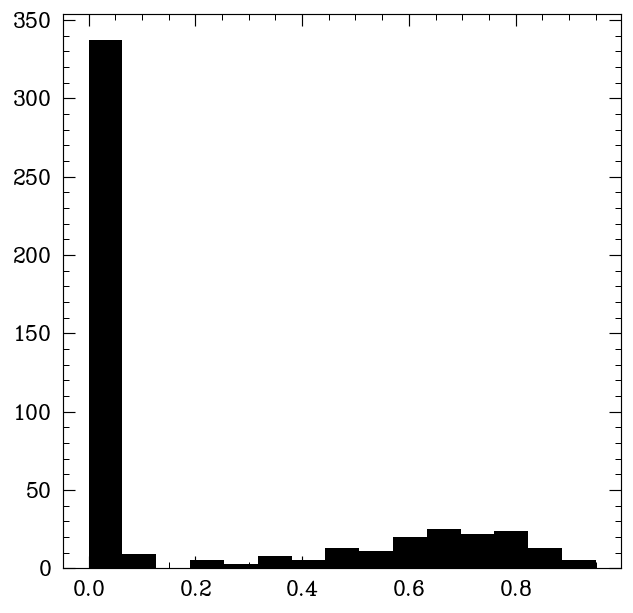

In [13]:
import matplotlib.pyplot as plt 
import smplotlib 
f1_scores =  [i['f1_score'] for i in results]
plt.hist(f1_scores)

In [32]:
import numpy as np
from s2cloudless import S2PixelCloudDetector

def fake_rgbnir_from_pan(pan_img):
    pan_img = pan_img.astype(np.float32)
    pan_img -= pan_img.min()
    pan_img /= pan_img.max()
    rgbnir = np.stack([pan_img] * 10, axis=-1)
    return rgbnir

results = []

for filename in tqdm(os.listdir(image_folder)[0:500]):
    if filename.endswith('.png') or filename.endswith('.tif'):
        image_path = os.path.join(image_folder, filename)
        mask_path = os.path.join(mask_folder, filename)

        pan_img = imread(image_path, as_gray=True)
        true_mask = imread(mask_path, as_gray=True)
        true_mask = (true_mask > 0.5).astype(np.uint8)

        # Create fake 4-band image
        fake_s2_input = fake_rgbnir_from_pan(pan_img)
        fake_s2_input_batch = fake_s2_input[np.newaxis, ...]

        # Create cloud detector
        cloud_detector = S2PixelCloudDetector(threshold=0.4, average_over=4, dilation_size=2, all_bands=False)

        # Predict cloud probability
        cloud_probs = cloud_detector.get_cloud_probability_maps(fake_s2_input_batch)

        # Apply threshold to get mask
        pred_mask = cloud_probs > 0.5

        precision = precision_score(true_mask.flatten(), pred_mask.flatten(), zero_division=0)
        recall = recall_score(true_mask.flatten(), pred_mask.flatten(), zero_division=0)
        f1 = f1_score(true_mask.flatten(), pred_mask.flatten(), zero_division=0)
        iou = jaccard_score(true_mask.flatten(), pred_mask.flatten(), zero_division=0)
        accuracy = accuracy_score(true_mask.flatten(), pred_mask.flatten())
        results.append({
            'filename': filename,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'iou': iou, 
            'accuracy':accuracy,
        })

100%|██████████| 500/500 [07:56<00:00,  1.05it/s]


(array([130.,  48., 118.,  21.,  21.,  18.,  19.,  19.,   5.,   8.,  14.,
         11.,  12.,  18.,  38.]),
 array([7.62939453e-06, 6.66735331e-02, 1.33339437e-01, 2.00005341e-01,
        2.66671244e-01, 3.33337148e-01, 4.00003052e-01, 4.66668955e-01,
        5.33334859e-01, 6.00000763e-01, 6.66666667e-01, 7.33332570e-01,
        7.99998474e-01, 8.66664378e-01, 9.33330282e-01, 9.99996185e-01]),
 <BarContainer object of 15 artists>)

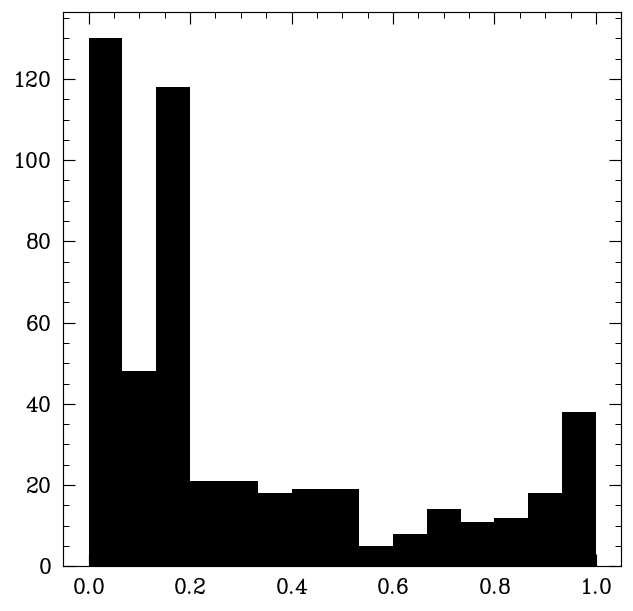

In [33]:
import matplotlib.pyplot as plt 
import smplotlib 
f1_scores =  [i['accuracy'] for i in results]
plt.hist(f1_scores)

array([[[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]]]])